<a href="https://colab.research.google.com/github/dolmani38/AMD-GAN/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install tensorflow

In [1]:
if True:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Imports
import os
import time
import shutil
import numpy as np
from tqdm import tqdm
from scipy.linalg import sqrtm
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Reshape, Dropout, Flatten

from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam

In [3]:
# Parameters
ALPHA = 0.2
GAUSS_SD = 0.02
MOMENTUM = 0.9
DROPOUT = 0.4

ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.99
GEN_LEARNING_RATE = 0.0001
DIS_LEARNING_RATE = 0.0004

MAX_ITER = 30000
NUM_CLASSES = 10
SAVE_PERIOD = 250
TRAIN_BATCH_SIZE = 128
EVAL_BATCH_SIZE = 128
FID_BATCH_SIZE = 1000

LATENT_DIM = 100
GENERATOR_INPUT = (100,)
DISCRIMINATOR_INPUT = (32, 32, 3)
INCEPTION_SHAPE = (299, 299, 3)

GRID_SIZE = 8
GRID_IMGS = 64  # GRID_SIZE * GRID_SIZE

In [6]:
# Create save directories
os.makedirs('./drive/MyDrive/DCGAN', exist_ok=True)
os.makedirs('./drive/MyDrive/DCGAN/train_images', exist_ok=True)

In [5]:
def preprocess(image):
    """
    Converts the pixel values to the interval [-1. 1]
    :param image: Image matrix
    :return: Scaled images
    """
    return (image / 255) * 2 - 1


def generate_latent_samples(n_samples, sample_size):  
    """
    Creates latent samples to be fed into the generator
    :param n_samples: Number of samples to be generated
    :param sample_size: Dimesion on each sample
    :return: Latent samples of given size
    """
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))


def generate_labels(n_samples):
    """
    Generates an array of ones(TRUE) and zeroes(FALSE) labels
    :param n_samples: The number of samples
    :return: Labels
    """
    return np.ones([n_samples, 1]), np.zeros([n_samples, 1])


def smooth_positive_labels(y):
    """
    Label smoothing postive labels to [0.9, 1.0]
    :param y: label
    :return: Smoothed labels
    """
    return y - 0.1 + (np.random.random(y.shape) * 0.1)


def smooth_negative_labels(y):
    """
    Label smoothing postive labels to [0, 0.1]
    :param y: label
    :return: Smoothed labels
    """
    return y + (np.random.random(y.shape) * 0.1)

In [6]:
def plot_image_grid(epoch, generated_images):
    """
    Plots the grid of images generated and end of each epoch
    :param epoch: the epoch number
    :param generated_images: List of generated images (atleast GRID_IMGS)
    :return: None
    """

    fig = plt.figure(figsize=(GRID_SIZE, GRID_SIZE))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.001, hspace=0.001)

    for ind in range(GRID_IMGS):
        ax = fig.add_subplot(GRID_SIZE, GRID_SIZE, ind + 1, xticks=[], yticks=[])
        ax.imshow(np.uint8(((generated_images[ind] + 1) / 2) * 255), cmap='gray')

    plt.savefig('./drive/MyDrive/DCGAN/train_images/image_iteration_{:05d}.png'.format(epoch + 1))
    plt.close()


def plot_final_grid(generated_images):
    """
    Plots the grid of images generated from final model
    :param generated_images: List of generated images (atleast GRID_IMGS)
    :return: None
    """

    fig = plt.figure(figsize=(GRID_SIZE, GRID_SIZE))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.001, hspace=0.001)

    for ind in range(GRID_IMGS):
        ax = fig.add_subplot(GRID_SIZE, GRID_SIZE, ind + 1, xticks=[], yticks=[])
        ax.imshow(np.uint8(((generated_images[ind] + 1) / 2) * 255), cmap='gray')

    plt.savefig('./drive/MyDrive/DCGAN/generated_image_grid.png')
    plt.savefig('./drive/MyDrive/DCGAN/results/DCGAN.png')
    plt.show()

In [7]:
# The following FID calculation code has been adapted from Machine learning mastery
# https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/

# Inceptionv3 model for FID calculation
from tensorflow.keras.applications.inception_v3 import InceptionV3

inception = InceptionV3(include_top=False, pooling='avg', input_shape=INCEPTION_SHAPE)


def scale_images(images, new_shape):
    """
    Scales images into new shape by interpolation since inception model requires that
    :param images: List of images
    :param new_shape: The transformed shape
    :return: Transformed images
    """

    images_list = list()

    for image in images:
        new_image = resize(image, new_shape)
        images_list.append(new_image)
    
    return np.asarray(images_list)


def calculate_fid(model, images1, images2):
    """

    Calculates the FID with the inception last layer activations
    :param model: THe model (eg: inception)
    :param images1: List of images grouo 1
    :param images1: List of images grouo 2
    :return: FID score
    """
    
    act1 = model.predict(images1)
    act2 = model.predict(images2)

    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    ssdiff = np.sum((mu1 - mu2) ** 2.0)

    covmean = sqrtm(sigma1.dot(sigma2))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Equation for FID score calculation
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)  

    return fid

87916544/87910968 [==============================] - 3s 0us/step


In [10]:
def discriminator_model():
    """
    Create and return a discriminator model
    :return: discriminator model
    """

    Discriminator = Sequential(name='Discriminator')

    # Downsampling : 32x32x3 --> 16x16x64
    Discriminator.add(Conv2D(filters=64, kernel_size=(5, 5), strides=2, padding='same', 
                             kernel_initializer=RandomNormal(stddev=GAUSS_SD), 
                             input_shape=DISCRIMINATOR_INPUT))
    Discriminator.add(LeakyReLU(ALPHA))

    # Downsampling : 16x16x64 --> 8x8x128
    Discriminator.add(Conv2D(filters=128, kernel_size=(5, 5), strides=2, padding='same'))
    Discriminator.add(BatchNormalization(momentum=MOMENTUM))
    Discriminator.add(LeakyReLU(ALPHA))

    # Downsampling : 8x8x128 --> 4x4x256
    Discriminator.add(Conv2D(filters=256, kernel_size=(5, 5), strides=2, padding='same'))
    Discriminator.add(BatchNormalization(momentum=MOMENTUM))
    Discriminator.add(LeakyReLU(ALPHA))

    # Downsampling : 4x4x256 --> 2x2x512
    Discriminator.add(Conv2D(filters=512, kernel_size=(5, 5), strides=2, padding='same'))
    Discriminator.add(BatchNormalization(momentum=MOMENTUM))
    Discriminator.add(LeakyReLU(ALPHA))

    # Fully Connected Layer (classifier) , 2x2x512 (2048) --> 1
    Discriminator.add(Flatten())
    Discriminator.add(Dropout(DROPOUT))
    Discriminator.add(Dense(1, activation='sigmoid'))

    return Discriminator


def generator_model():
    """
    Create and return a discriminator model
    :return: discriminator model
    """

    Generator = Sequential(name='Generator')

    # Fully Connected layer --> 512 activation maps of 2x2  
    Generator.add(Dense(units=512 * 2 * 2, input_shape=GENERATOR_INPUT, kernel_initializer=RandomNormal(stddev=GAUSS_SD)))
    Generator.add(Reshape((2, 2, 512)))
    Generator.add(BatchNormalization(momentum=MOMENTUM))
    Generator.add(LeakyReLU(ALPHA))

    # Upsampling : 2x2x512 --> 4x4x256 
    Generator.add(Conv2DTranspose(filters=256, kernel_size=(5, 5), strides=2, padding='same', kernel_initializer=RandomNormal(stddev=GAUSS_SD)))
    Generator.add(BatchNormalization(momentum=MOMENTUM))
    Generator.add(LeakyReLU(ALPHA))

    # Upsampling : 4x4x256 --> 8x8x128 
    Generator.add(Conv2DTranspose(filters=128, kernel_size=(5, 5), strides=2, padding='same', kernel_initializer=RandomNormal(stddev=GAUSS_SD)))
    Generator.add(BatchNormalization(momentum=MOMENTUM))
    Generator.add(LeakyReLU(ALPHA))

    # Upsampling : 8x8x128 --> 16x16x64
    Generator.add(Conv2DTranspose(filters=64, kernel_size=(5, 5), strides=2, padding='same', kernel_initializer=RandomNormal(stddev=GAUSS_SD)))
    Generator.add(BatchNormalization(momentum=MOMENTUM))
    Generator.add(LeakyReLU(ALPHA))

    # Upsampling : 16x16x63 --> 32x32x3 
    Generator.add(Conv2DTranspose(filters=3, kernel_size=(5, 5), strides=2, padding='same', kernel_initializer=RandomNormal(stddev=GAUSS_SD), activation='tanh'))

    return Generator

def DCGAN_model():
    """
    Creates and returns the GAN, gnerator and discriminator models
    :return: GAN, gnerator and discriminator models
    """
    
    # Generator model
    Generator = generator_model()

    # Discriminator model
    Discriminator = discriminator_model()
    Discriminator.compile(optimizer=Adam(lr=DIS_LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2), loss='binary_crossentropy', metrics=['binary_accuracy'])

    # GAN model
    GAN = Sequential([Generator, Discriminator])
    GAN.compile(optimizer=Adam(lr=GEN_LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2), loss='binary_crossentropy', metrics=['binary_accuracy'])

    return GAN, Generator, Discriminator


In [11]:
def train_DCGAN():
    """
    Function to train the GAN, gnerator and discriminator models
    """

    best_fid_score = 1000
    if os.path.exists('./drive/MyDrive/DCGAN/best_fid_score.txt'):
        best_fid_score = float(next(open('./drive/MyDrive/DCGAN/best_fid_score.txt')))
        print('Best FID Score :', best_fid_score)

    # Calculate the previous iteration counts if the model was trained before
    prev_iters = 0
    if os.path.exists('./drive/MyDrive/DCGAN/fid_scores.txt'):
        prev_iters = (sum(1 for line in open('./drive/MyDrive/DCGAN/fid_scores.txt'))) * SAVE_PERIOD
        print('Previous iteration count :', prev_iters)

    # Generate labels for training and evaluation batches
    Y_train_real, Y_train_fake = generate_labels(TRAIN_BATCH_SIZE)
    Y_eval_real, Y_eval_fake = generate_labels(EVAL_BATCH_SIZE)

    # Load existing model if exists or create a new model
    if os.path.exists('./drive/MyDrive/DCGAN/model/DCGAN/best_GAN'):
        print("Saved model found. Loading model.")

        generator = load_model('./drive/MyDrive/DCGAN/model/DCGAN/best_generator')
        print("Loaded Generator")

        discriminator = load_model('./drive/MyDrive/DCGAN/model/DCGAN/best_discriminator')
        print("Loaded Discriminator")

        GAN = load_model('./drive/MyDrive/DCGAN/model/DCGAN/best_GAN')
        print("Loaded GAN")

        discriminator.compile(optimizer=Adam(lr=DIS_LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2), loss = 'binary_crossentropy', metrics=['accuracy'])
        GAN.compile(optimizer=Adam(lr=GEN_LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2), loss = 'binary_crossentropy', metrics=['accuracy'])

    else:
        GAN, generator, discriminator = DCGAN_model()
        print("Created new GAN, Generator and Discriminator")

    for iters in range(MAX_ITER):
        print("Iteration : ", iters + prev_iters)

        # TRAIN - DISCRIMINATOR MODEL
        discriminator.trainable = True

        # Sample a train subset from real images
        X_batch_real = X_train[np.random.choice(X_train.shape[0], TRAIN_BATCH_SIZE, replace=True), :]

        # Generate fake samples
        latent_samples = generate_latent_samples(TRAIN_BATCH_SIZE, LATENT_DIM)
        X_batch_fake = generator.predict_on_batch(latent_samples)

        # Train the discriminator to detect real and fake images 
        discriminator.train_on_batch(X_batch_real, smooth_positive_labels(Y_train_real))
        discriminator.train_on_batch(X_batch_fake, smooth_negative_labels(Y_train_fake))

        # TRAIN - GENERATOR MODEL
        discriminator.trainable = False
        GAN.train_on_batch(latent_samples, Y_train_real)

        # Calculate and record loss, FID for every SAVE_PERIOD iterations
        if (iters + 1) % SAVE_PERIOD == 0:
            # Generate latent samples
            latent_samples = generate_latent_samples(EVAL_BATCH_SIZE, 100)
            GAN_images = generator.predict_on_batch(latent_samples)

            # Sample a subset of test images
            X_eval_real = X_test[np.random.choice(len(X_test), EVAL_BATCH_SIZE, replace=True), :]

            # Calculating losses
            discriminator_loss_real = discriminator.test_on_batch(X_eval_real, Y_eval_real)
            discriminator_loss_fake = discriminator.test_on_batch(GAN_images, Y_eval_fake)
            discriminator_loss_batch = 0.5 * (round(discriminator_loss_real[0], 10) + round(discriminator_loss_fake[0], 10))

            generator_loss_batch = GAN.test_on_batch(latent_samples, Y_eval_real)

            with open('./drive/MyDrive/DCGAN/losses.txt', "a") as file:
                file.write("DIS_LOSS_BATCH: {}, GEN_LOSS_BATCH: {}".format(generator_loss_batch, round(generator_loss_batch[0], 10))) 
                file.write('\n')

            # Calculation FID 
            latent_samples = generate_latent_samples(FID_BATCH_SIZE, LATENT_DIM)
            GAN_images = generator.predict_on_batch(latent_samples)
            GAN_images = scale_images(GAN_images.astype('float32'), INCEPTION_SHAPE)

            X_test_batch = X_test[np.random.choice(len(X_test), FID_BATCH_SIZE, replace=True), :]
            X_test_batch = scale_images(X_test_batch.astype('float32'), INCEPTION_SHAPE)

            cur_fid_score = calculate_fid(inception, X_test_batch, GAN_images)

            with open('./drive/MyDrive/DCGAN/fid_scores.txt', "a") as file:
                file.write("{} {}".format(iters + 1 + prev_iters, round(cur_fid_score, 5)))
                file.write('\n')

            # Plot and save a grid of generated images
            plot_image_grid(iters + prev_iters, GAN_images)

            # If current model better than previous saved (best) model, save the new one
            if cur_fid_score < best_fid_score:
                best_fid_score = cur_fid_score

                with open('./drive/MyDrive/DCGAN/best_fid.txt', "w") as file:
                    file.write(str(cur_fid_score))

                # Save the Generator model
                if os.path.exists('./drive/MyDrive/DCGAN/model/DCGAN/best_generator'):
                    shutil.rmtree('./drive/MyDrive/DCGAN/model/DCGAN/best_generator')

                generator.save('./drive/MyDrive/DCGAN/model/DCGAN/best_generator')

                # Save the Discriminator model
                if os.path.exists('./drive/MyDrive/DCGAN/model/DCGAN/best_discriminator'):
                    shutil.rmtree('./drive/MyDrive/DCGAN/model/DCGAN/best_discriminator')

                discriminator.save('./drive/MyDrive/DCGAN/model/DCGAN/best_discriminator')

                # Save the GAN model
                if os.path.exists('./drive/MyDrive/DCGAN/model/DCGAN/best_GAN'):
                    shutil.rmtree('./drive/MyDrive/DCGAN/model/DCGAN/best_GAN')

                GAN.save('./drive/MyDrive/DCGAN/model/DCGAN/best_GAN')
    return

In [10]:
# Loading Data
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

X_train = preprocess(X_train)
X_test = preprocess(X_test)


170500096/170498071 [==============================] - 12s 0us/step


In [ ]:

# Training the model
train_DCGAN()

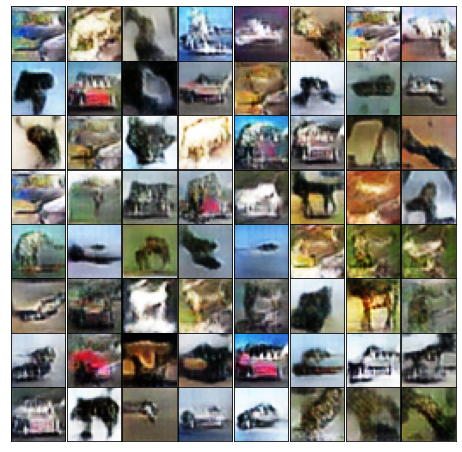

FID score for DCGAN with BCE loss :  95.53100218792164


In [11]:
# Load best generator model
generator = load_model('./drive/MyDrive/DCGAN/model/DCGAN/best_generator') 
 
# Plot GRID_IMGS generated images from the model in a GRID_SIZE by GRID_SIZE grid 
gan_images = generator.predict(generate_latent_samples(GRID_IMGS, LATENT_DIM))
plot_final_grid(gan_images) 

# Calcualte the FID score
GAN_images = generator.predict(generate_latent_samples(FID_BATCH_SIZE, LATENT_DIM))
GAN_images = scale_images(GAN_images.astype('float32'), INCEPTION_SHAPE)

X_test_batch = X_test[np.random.choice(len(X_test), FID_BATCH_SIZE, replace=True), :]
X_test_batch = scale_images(X_test_batch.astype('float32'), INCEPTION_SHAPE)

FID = calculate_fid(inception, X_test_batch, GAN_images)

print("FID score for DCGAN with BCE loss : ", FID)


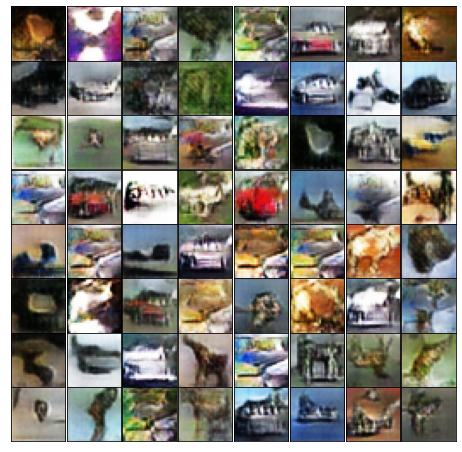

In [12]:
"""
Run for evaluation purposes (works even if above cells are not executed)
"""

import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline

GRID_SIZE = 8
GRID_IMGS = GRID_SIZE ** 2
LATENT_DIM = 100


def plot_final_grid(generated_images):
    """
    Plots the grid of images generated from final model
    :param generated_images: List of generated images (atleast GRID_IMGS)
    :return: None
    """

    fig = plt.figure(figsize=(GRID_SIZE, GRID_SIZE))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.001, hspace=0.001)

    for ind in range(GRID_IMGS):
        ax = fig.add_subplot(GRID_SIZE, GRID_SIZE, ind + 1, xticks=[], yticks=[])
        ax.imshow(np.uint8(((generated_images[ind] + 1) / 2) * 255), cmap='gray')

    plt.savefig('./drive/MyDrive/DCGAN/generated_image_grid.png')
    plt.savefig('./drive/MyDrive/DCGAN/results/DCGAN.png')
    plt.show()


def generate_latent_samples(n_samples, sample_size):  
    """
    Creates latent samples to be fed into the generator
    :param n_samples: Number of samples to be generated
    :param sample_size: Dimesion on each sample
    :return: Latent samples of given size
    """
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

# Load best generator model
generator = load_model('./drive/MyDrive/DCGAN/model/DCGAN/best_generator') 

# Pot GRID_IMGS generated images from the model in a GRID_SIZE by GRID_SIZE grid 
gan_images = generator.predict(generate_latent_samples(GRID_IMGS, LATENT_DIM))
plot_final_grid(gan_images)